In [1]:
import numpy as np
import pandas as pd
from os import listdir, makedirs, walk
from os.path import isdir, isfile, join, exists, expanduser
from tqdm import tqdm_notebook

In [2]:
train_folder      = 'data/train'
validation_folder = 'data/validation'
weights_folder    = 'models/'

# Create weights folder to save model weights
if not exists(weights_folder):
    makedirs(weights_folder)
    
ext = '.jpg'
classes = [fldr for fldr in listdir(train_folder) if isdir(join(train_folder, fldr))]
num_classes = len(classes)
train_samples = sum([len(files) for r, d, files in walk(train_folder)])
validation_samples = sum([len(files) for r, d, files in walk(validation_folder)])

print ("Classes: {}, Training samples: {}, Validation samples: {}".format(num_classes, train_samples, validation_samples))

Classes: 120, Training samples: 8122, Validation samples: 2100


/home/paperspace/anaconda3/envs/tensorflow_py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


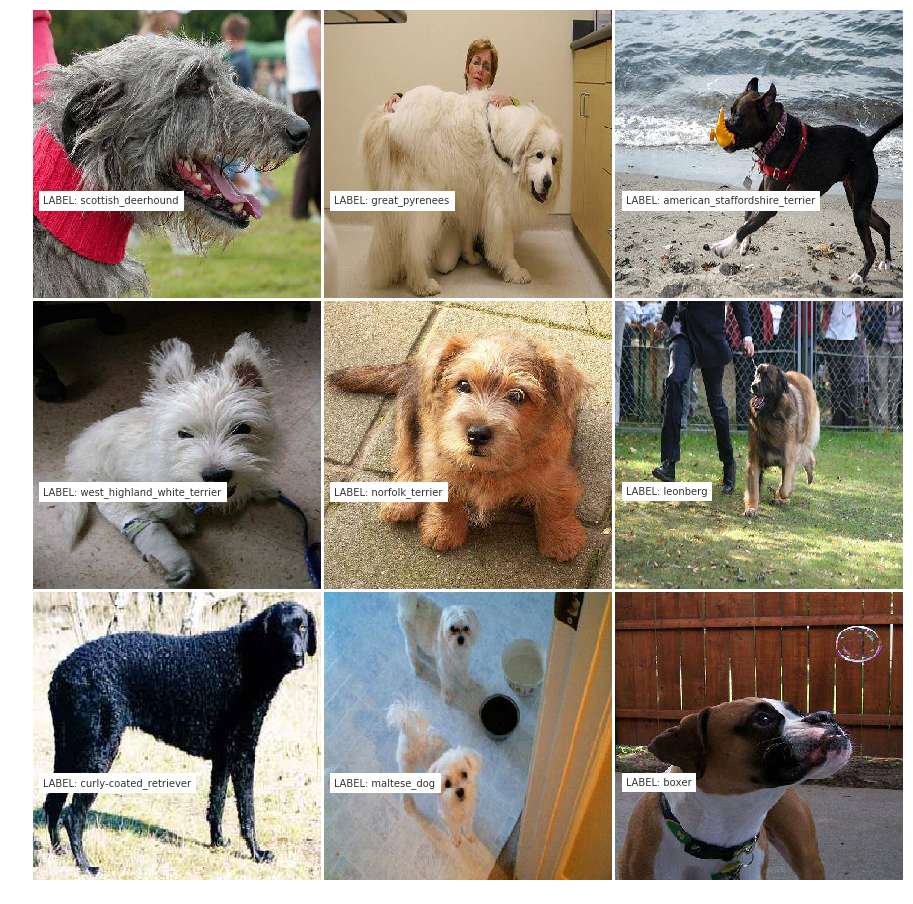

In [3]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

# options
INPUT_SIZE = 299
BATCH_SIZE = 16

fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.05)

for i, cls in enumerate(np.random.choice(classes, 9)):
    ax = grid[i]
    img_file = np.random.choice(listdir(join(train_folder, cls)))
    img = image.load_img(join(train_folder, cls, img_file), target_size=(INPUT_SIZE,INPUT_SIZE))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.text(10, 200, 'LABEL: %s' % cls, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
plt.show()

In [4]:
from keras.applications.xception import Xception
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input

In [5]:
# Create the base pre-trained model
base_model = Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer for num_classes
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [6]:
# From https://github.com/bckenstler/CLR for Cyclical Learning Rate

from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [7]:
# Defining callbacks during model training
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint

# checkpoints
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
STAMP = "{}_dog_breed_model".format(datetime.date.today().strftime("%Y-%m-%d"))

bst_model_path = "models/{}.h5".format(STAMP)
model_checkpoint = ModelCheckpoint(bst_model_path,
                                   save_best_only=True,
                                   save_weights_only=True)

# Authors suggest setting step_size = (2-8) x (training iterations in epoch)
step_size = 2000
clr = CyclicLR(base_lr=0.0001,
               max_lr=0.001,
               step_size=step_size,
               mode='exp_range',
               gamma=0.99994)

In [8]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [25]:
# From https://nbviewer.jupyter.org/gist/embanner/6149bba89c174af3bfd69537b72bca74
from keras.preprocessing.image import ImageDataGenerator, array_to_img

def preprocess_input_xception(x):
    """Wrapper around keras.applications.xception.preprocess_input()
    to make it compatible for use with keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument.
    
    Parameters
    ----------
    x : a numpy 3darray (a single image to be preprocessed)
    
    Note we cannot pass keras.applications.xception.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.
    
    Returns a numpy 3darray (the preprocessed image).
    
    """
    from keras.applications.xception import preprocess_input
    X = preprocess_input(np.expand_dims(x.copy(), axis=0))
    return X[0]

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_xception,
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(directory='data/train',
                                                    target_size=(INPUT_SIZE,INPUT_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_xception)
validation_generator = validation_datagen.flow_from_directory(directory='data/validation',
                                                              target_size=(INPUT_SIZE,INPUT_SIZE),
                                                              batch_size=BATCH_SIZE,
                                                              class_mode='categorical')

Found 8122 images belonging to 120 classes.
Found 2100 images belonging to 120 classes.


In [24]:
from keras.applications.xception import preprocess_input
x_train = np.zeros((1, INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
img = np.ones((INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
x = preprocess_input_xception(img)
x_train[0] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))
x_train[0]

Train Images shape: (1, 299, 299, 3) size: 268,203


array([[[-0.99215686, -0.99215686, -0.99215686],
        [-0.99215686, -0.99215686, -0.99215686],
        [-0.99215686, -0.99215686, -0.99215686],
        ...,
        [-0.99215686, -0.99215686, -0.99215686],
        [-0.99215686, -0.99215686, -0.99215686],
        [-0.99215686, -0.99215686, -0.99215686]],

       [[-0.99215686, -0.99215686, -0.99215686],
        [-0.99215686, -0.99215686, -0.99215686],
        [-0.99215686, -0.99215686, -0.99215686],
        ...,
        [-0.99215686, -0.99215686, -0.99215686],
        [-0.99215686, -0.99215686, -0.99215686],
        [-0.99215686, -0.99215686, -0.99215686]],

       [[-0.99215686, -0.99215686, -0.99215686],
        [-0.99215686, -0.99215686, -0.99215686],
        [-0.99215686, -0.99215686, -0.99215686],
        ...,
        [-0.99215686, -0.99215686, -0.99215686],
        [-0.99215686, -0.99215686, -0.99215686],
        [-0.99215686, -0.99215686, -0.99215686]],

       ...,

       [[-0.99215686, -0.99215686, -0.99215686],
        [-0

In [26]:
hist = model.fit_generator(train_generator,
                           steps_per_epoch=train_samples // BATCH_SIZE,
                           epochs=5, callbacks=[early_stopping, model_checkpoint, clr],
                           validation_data=validation_generator,
                           validation_steps=validation_samples // BATCH_SIZE)

Epoch 1/5


StopIteration: output array is read-only

Results with original approach:

Epoch 1/50
573/573 [==============================] - 188s 329ms/step - loss: 2.6888 - acc: 0.4172 - val_loss: 0.5156 - val_acc: 0.8356
Epoch 2/50
573/573 [==============================] - 186s 325ms/step - loss: 1.1958 - acc: 0.6704 - val_loss: 0.4518 - val_acc: 0.8423
Epoch 3/50
573/573 [==============================] - 186s 325ms/step - loss: 1.2034 - acc: 0.6921 - val_loss: 0.4862 - val_acc: 0.8519
Epoch 4/50
573/573 [==============================] - 185s 323ms/step - loss: 1.2603 - acc: 0.6965 - val_loss: 0.4370 - val_acc: 0.8673
Epoch 5/50
573/573 [==============================] - 186s 324ms/step - loss: 1.2512 - acc: 0.7045 - val_loss: 0.4166 - val_acc: 0.8644
Epoch 6/50
 98/573 [====>.........................] - ETA: 2:21 - loss: 1.0983 - acc: 0.7392